In [1]:
#To get detailed description if get CUDA error
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import time

/home/mohammed/anaconda3/envs/scib_metrics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:Global seed set to 0


In [4]:
st = time.time()

In [5]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [6]:
# url = 'https://drive.google.com/uc?id=1Vh6RpYkusbGIZQC8GMFe3OKVDk5PWEpC'
# output = 'pbmc.h5ad'
# gdown.download(url, output, quiet=False)

In [7]:
adata = sc.read('pbmc.h5ad')
# adata = sc.pp.subsample(adata, fraction=None, n_obs=5000, random_state=0, copy=True)

In [8]:
adata.X = adata.layers["counts"].copy()

In [9]:
condition_key = 'batch'
target_conditions = ['10X']

trvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [10]:
# target_conditions = ["10X"]
removed_viallni = ['Villani']
adata_villani_removed = adata[~adata.obs.study.isin(removed_viallni)].copy()
chosen_source = ['Freytag']
source_adata = adata_villani_removed[adata_villani_removed.obs.study.isin(chosen_source)].copy()
source_conditions = source_adata.obs['batch'].unique().tolist()
print(adata_villani_removed.obs['batch'])
source_adata, source_conditions

index
AAACCTGCAGCGAACA-1-Oetjen_A                Oetjen_A
AAACCTGCATGTCCTC-1-Oetjen_A                Oetjen_A
AAACCTGGTCGACTGC-1-Oetjen_A                Oetjen_A
AAACCTGGTCGCTTCT-1-Oetjen_A                Oetjen_A
AAACCTGTCCCGACTT-1-Oetjen_A                Oetjen_A
                                          ...      
TTTGTCAAGCTCCTTC-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCAAGCTGAAAT-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCATCATTC-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCTCGCTTG-1-Sun_sample4_TC    Sun_sample4_TC
TTTGTCATCTGTCTCG-1-Sun_sample4_TC    Sun_sample4_TC
Name: batch, Length: 32484, dtype: category
Categories (9, object): ['10X', 'Freytag', 'Oetjen_A', 'Oetjen_P', ..., 'Sun_sample1_CS', 'Sun_sample2_KC', 'Sun_sample3_TB', 'Sun_sample4_TC']


(AnnData object with n_obs × n_vars = 3347 × 12303
     obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
     layers: 'counts',
 ['Freytag'])

In [11]:
adata_tasks = adata_villani_removed[~adata_villani_removed.obs.study.isin(chosen_source)].copy()
adata_tasks_obs = adata_tasks.obs['batch']
tasks_list = list(set(adata_tasks_obs))
tasks_list

['10X',
 'Oetjen_A',
 'Sun_sample4_TC',
 'Sun_sample1_CS',
 'Sun_sample3_TB',
 'Sun_sample2_KC',
 'Oetjen_P',
 'Oetjen_U']

In [12]:
source_adata.raw = source_adata

In [13]:
source_adata

AnnData object with n_obs × n_vars = 3347 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [14]:
sc.pp.normalize_total(source_adata)

In [15]:
sc.pp.log1p(source_adata)

In [16]:
sc.pp.highly_variable_genes(
    source_adata,
    n_top_genes=2000,
    batch_key="batch",
    subset=True)

In [17]:
source_adata.X = source_adata.raw[:, source_adata.var_names].X

In [18]:
source_adata

AnnData object with n_obs × n_vars = 3347 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [19]:
trvae = sca.models.TRVAE(
    adata=source_adata,
    condition_key=condition_key,
    conditions=source_conditions,
    hidden_layer_sizes=[128, 128],
)


INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 1
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 1
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 



In [20]:
trvae.train(
    n_epochs=trvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=0,
    learning_approach='LR+EWC',
)

LR+EWC is happening!
 |████----------------| 23.2%  - val_loss: 457.0139363607 - val_recon_loss: 453.5393168132 - val_kl_loss: 6.0428277651 - val_mmd_loss: 0.00000000000
ADJUSTED LR
 |████----------------| 24.6%  - val_loss: 441.0645141602 - val_recon_loss: 437.3930460612 - val_kl_loss: 6.0188013713 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Calculating fisher information!
Saving best state of network...
Best State was in Epoch 101


In [21]:
adata_latent = sc.AnnData(trvae.get_latent())
adata_latent.obs["cell_type"] = source_adata.obs["final_annotation"].tolist()
adata_latent.obs["batch"] = source_adata.obs["batch"].tolist()

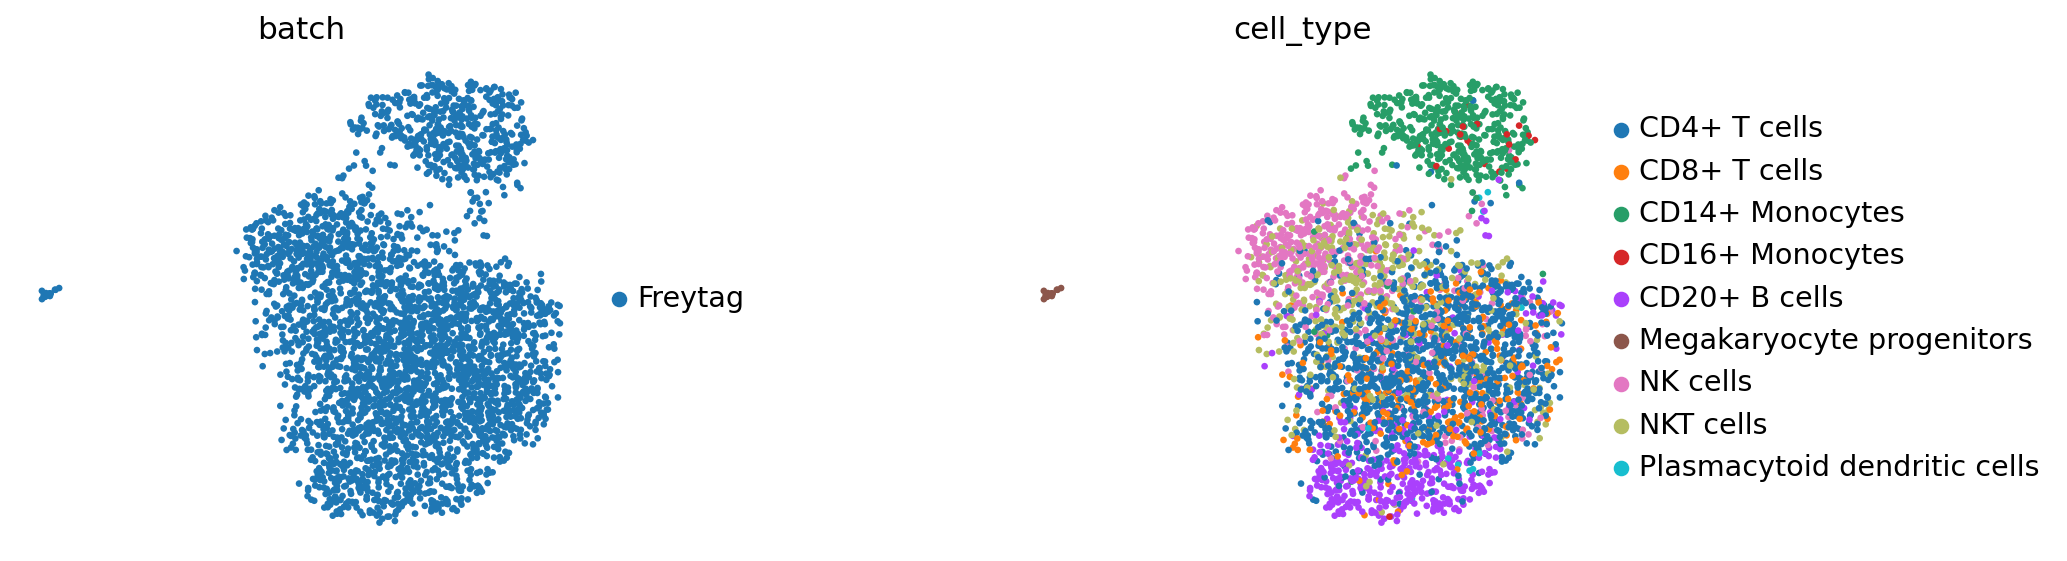

In [22]:
sc.pp.neighbors(adata_latent, n_neighbors=8)
sc.tl.leiden(adata_latent)
sc.tl.umap(adata_latent)
sc.pl.umap(adata_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [23]:
ref_path = 'reference_model_PBMC/'
trvae.save(ref_path, overwrite=True)

In [24]:
for ID, task in enumerate(tasks_list, start=1): #adata_tasks[1:] if you wanna skip the first item
    print(ID, task)
    task_i = adata_tasks[adata_tasks.obs['batch'].isin([task])]
    task_i = task_i[:, source_adata.var_names]
    new_trvae_LR_1_EWC_1 = sca.models.TRVAE.load_query_data(adata=task_i,
                                                 learning_approach = 'LR+EWC',
                                                 model=ref_path)
    new_trvae_LR_1_EWC_1.train(
    n_epochs=surgery_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    ID=ID,
    weight_decay=0,
    learning_approach = 'LR+EWC'
    )
    
    ref_path = 'reference_model_PBMC/'
    new_trvae_LR_1_EWC_1.save(ref_path, overwrite=True)

1 10X
View of AnnData object with n_obs × n_vars = 10727 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
	Input Layer in, out and cond: 2000 128 2
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 2
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 2000 

LR+EWC is happening!
 |██------------------| 14.6%  - val_loss: 828.0461968316 - val_recon_loss: 820.8906182183 - val_kl_loss: 19.8766187032 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |███-----------------| 18.8%  - val_loss: 827.1674804688 - val_recon_loss: 818.2914903429 - val_kl_loss: 19.0881364610 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |████----------------| 24.4%  - val_loss: 831.3174370660 - val_recon_loss: 819.9501885308 - val_kl_loss: 18.7888482412 - va

 |█-------------------| 7.2%  - val_loss: 700.7888590495 - val_recon_loss: 697.1360677083 - val_kl_loss: 20.8731562297 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |██------------------| 11.6%  - val_loss: 689.5922648112 - val_recon_loss: 683.8711547852 - val_kl_loss: 20.0740146637 - val_mmd_loss: 0.0000000000
ADJUSTED LR
 |██------------------| 13.0%  - val_loss: 690.9946289062 - val_recon_loss: 684.5863240560 - val_kl_loss: 20.0259405772 - val_mmd_loss: 0.0000000000
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Calculating fisher information!
Saving best state of network...
Best State was in Epoch 43
8 Oetjen_U
View of AnnData object with n_obs × n_vars = 3730 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'coun

In [25]:
target_adata = adata_villani_removed[~adata_villani_removed.obs.study.isin(chosen_source)].copy()
target_adata = target_adata[:, source_adata.var_names]
target_adata

View of AnnData object with n_obs × n_vars = 29137 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

In [26]:
adata_full = source_adata.concatenate(target_adata, batch_key="ref_query")
adata_full

AnnData object with n_obs × n_vars = 32484 × 2000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'ref_query'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    layers: 'counts'

In [27]:
full_latent = sc.AnnData(new_trvae_LR_1_EWC_1.get_latent(adata_full.X, adata_full.obs[condition_key]))
full_latent.obs['cell_type'] = adata_full.obs["final_annotation"].tolist()
full_latent.obs['batch'] = adata_full.obs["batch"].tolist()

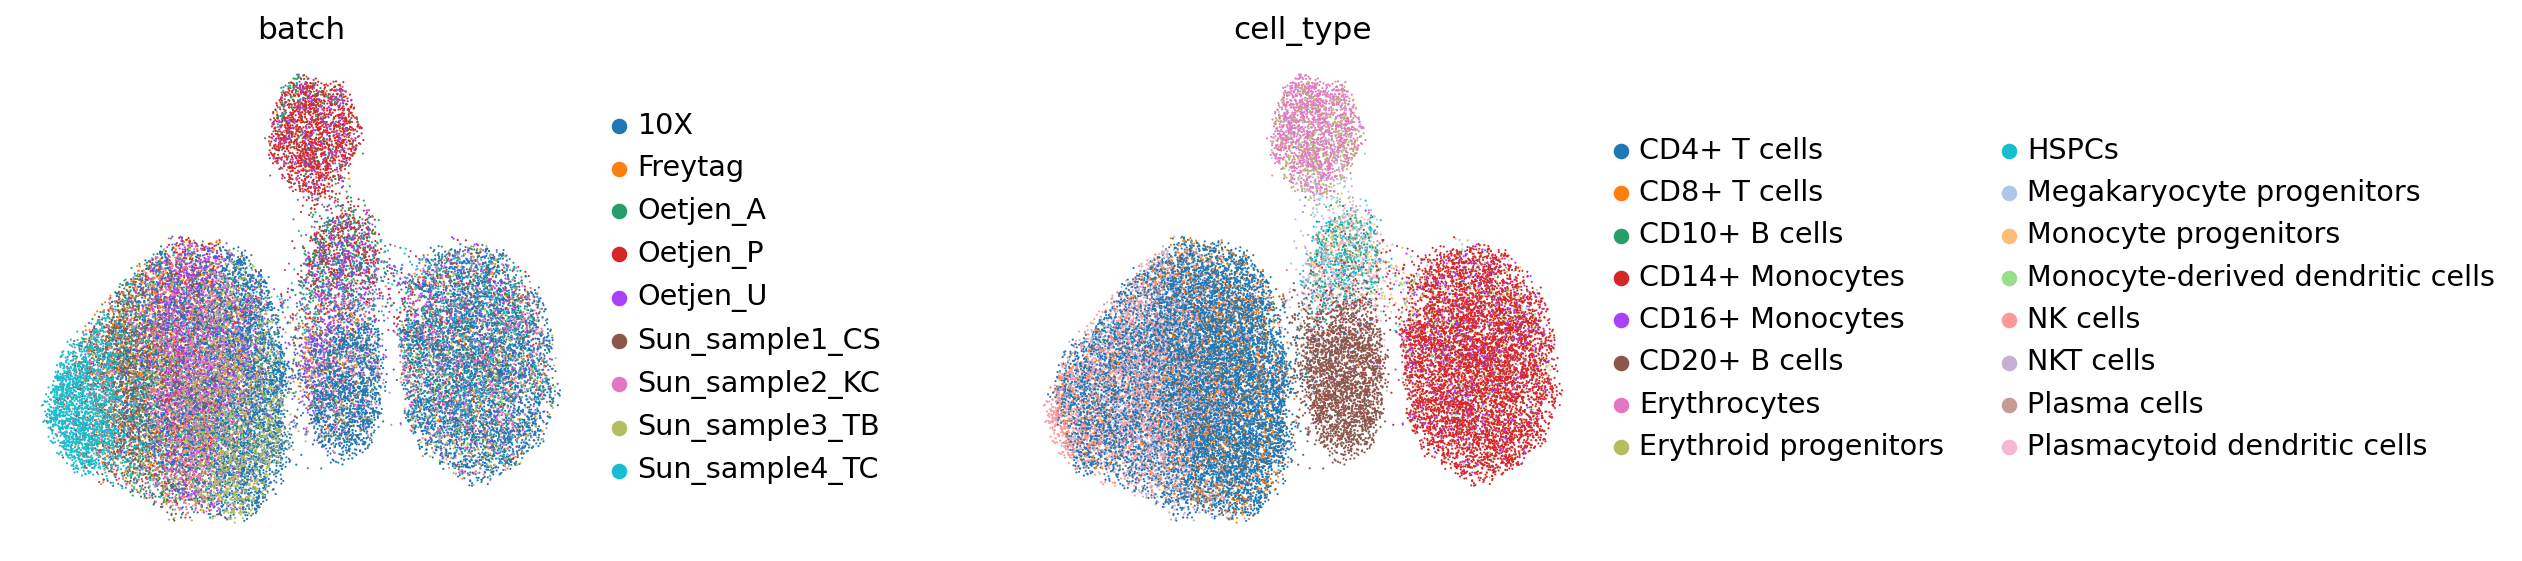

In [28]:
sc.pp.neighbors(full_latent, n_neighbors=8)
sc.tl.leiden(full_latent)
sc.tl.umap(full_latent)
sc.pl.umap(full_latent,
           color=['batch', 'cell_type'],
           frameon=False,
           wspace=0.6,
           )

In [29]:
X_LR_1_EWC_1 = new_trvae_LR_1_EWC_1.get_latent(adata_full.X, adata_full.obs[condition_key])
%store X_LR_1_EWC_1

Stored 'X_LR_1_EWC_1' (ndarray)


In [30]:
elapsed_time = time.time() - st
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Execution time: 05:28:02


In [31]:
import scanpy
import scib
arches_nb_graph=sc.pp.neighbors(full_latent, n_neighbors=8, n_pcs=None, use_rep='X')
Batch_corr_graph_conn_LR_1_EWC_1=scib.metrics.graph_connectivity(full_latent, 'batch')


Batch_corr_graph_conn_LR_1_EWC_1

0.6929523334865497

In [32]:
sc.tl.umap(full_latent)
Batch_corr_ASW_LR_1_EWC_1=scib.metrics.silhouette_batch(full_latent, batch_key='batch', group_key='cell_type', embed='X_umap')
Batch_corr_ASW_LR_1_EWC_1

/tmp/ipykernel_237/2173397468.py:2: DeprecationWarning: Keyword argument 'group_key' has been deprecated in favour of 'label_key'. 'group_key' will be removed in a future version.
  Batch_corr_ASW_LR_1_EWC_1=scib.metrics.silhouette_batch(full_latent, batch_key='batch', group_key='cell_type', embed='X_umap')


mean silhouette per group:                                   silhouette_score
group                                             
CD10+ B cells                             0.886318
CD14+ Monocytes                           0.904065
CD16+ Monocytes                           0.850988
CD20+ B cells                             0.894228
CD4+ T cells                              0.848765
CD8+ T cells                              0.851146
Erythrocytes                              0.799545
Erythroid progenitors                     0.927362
HSPCs                                     0.934071
Megakaryocyte progenitors                 0.772514
Monocyte progenitors                      0.670151
Monocyte-derived dendritic cells          0.873445
NK cells                                  0.843479
NKT cells                                 0.863599
Plasma cells                              0.772042
Plasmacytoid dendritic cells              0.776473


0.8417620492053356

In [33]:
Bio_cons_ASW_LR_1_EWC_1=scib.metrics.silhouette(full_latent, group_key='cell_type', embed='X_umap')
Bio_cons_ASW_LR_1_EWC_1

/tmp/ipykernel_237/3309905341.py:1: DeprecationWarning: Keyword argument 'group_key' has been deprecated in favour of 'label_key'. 'group_key' will be removed in a future version.
  Bio_cons_ASW_LR_1_EWC_1=scib.metrics.silhouette(full_latent, group_key='cell_type', embed='X_umap')


0.47403369285166264

In [34]:
isolated_labels_LR_1_EWC_1=scib.metrics.isolated_labels(full_latent, label_key='cell_type', batch_key='batch', embed='X_umap')
isolated_labels_LR_1_EWC_1

isolated labels: no more than 3 batches per label
Compute neighbors on rep X_umap
CD10+ B cells: 0.231375985977213
Compute neighbors on rep X_umap
Erythrocytes: 0.8098571828619434
Compute neighbors on rep X_umap
Erythroid progenitors: 0.3570300157977883
Compute neighbors on rep X_umap
Monocyte progenitors: 0.22466960352422907


0.4057331970402935

In [35]:
pcr_LR_1_EWC_1=scib.metrics.pcr_comparison(source_adata, adata, covariate='batch', embed=None, n_comps=50, scale=False, verbose=False)
pcr_LR_1_EWC_1

0.6530575501015305